In [1]:
import sys
import math
import matplotlib.pyplot as plt
import cv2
sys.path.append('../')

from scripts.point_cloud_utils import send_point_cloud
from pyngp.common import *
from tqdm import tqdm
import pyngp.pyngp as ngp
from  scripts.ros_utils import get_image_tf_pair, send_tf



In [2]:
width = 854
height = 480
spp = 1 # 1 is fast 8 is default

objects = ['table', 'truck', 'block']
testbed_map = {}
for obj in objects:
    testbed = ngp.Testbed()
    testbed.load_snapshot(f'../nerf/{obj}.ingp')
    testbed_map[obj] = testbed
def srgb_to_linear(img):
    limit = 0.04045
    return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

def linear_to_srgb(img):
    limit = 0.0031308
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

camera_matrix = testbed_map['table'].camera_matrix

testbed_map['block'].fov = testbed_map['table'].fov


14:28:39 SUCCESS  Initialized CUDA 12.0. Active GPU is #0: NVIDIA GeForce RTX 4090 [89]
14:28:39 INFO     Loading network snapshot from: ../nerf/table.ingp
14:28:42 DEBUG    GPUMemory: allocating 1.41 KB.
14:28:42 DEBUG    GPUMemory: allocating 144 B.
14:28:42 DEBUG    GPUMemory: allocating 144 B.
14:28:42 DEBUG    GPUMemory: allocating 144 B.
14:28:42 DEBUG    GPUMemory: allocating 144 B.
14:28:42 DEBUG    GPUMemory: allocating 8 B.
14:28:42 DEBUG    GPUMemory: allocating 1.12 KB.
14:28:42 DEBUG    GPUMemory: allocating 4 MB.
14:28:42 DEBUG    GPUMemory: allocating 8 MB.
14:28:42 DEBUG    GPUMemory: allocating 2 MB.
14:28:42 DEBUG    GPUMemory: allocating 64 KB.
14:28:42 INFO     GridEncoding:  Nmin=16 b=2 F=4 T=2^22 L=8
14:28:42 DEBUG    GridEncoding at level 0: resolution=16 params_in_level=4096
14:28:42 DEBUG    GridEncoding at level 1: resolution=32 params_in_level=32768
14:28:42 DEBUG    GridEncoding at level 2: resolution=64 params_in_level=262144
14:28:42 DEBUG    GridEncoding 

In [3]:
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
tf = tf[0]
ros_image = ros_image[0]

c2w = tf.copy()
c2w[0:3, 2] *= -1  # flip the y and z axis
c2w[0:3, 1] *= -1
c2w = c2w[[1, 0, 2, 3], :]
c2w[2, :] *= -1  # flip whole world upside down
tf_ngp = c2w
tf_ngp = tf_ngp[:-1, :]

testbed.set_nerf_camera_matrix(tf_ngp)
camera_matrix2 = testbed.camera_matrix.copy()

depth_buffer = 10000000*np.ones((height, width))
image_composed = np.zeros((height, width, 3))



for obj in objects:
    testbed = testbed_map[obj]
    camera_matrix_tmp = camera_matrix2.copy()
    if obj != 'table':
        tmp = (.2*(np.random.rand(3, 1)-.5) ).squeeze()
        tmp[2] = 0
        camera_matrix_tmp[:, -1] = camera_matrix_tmp[:, -1] + camera_matrix_tmp[:, :3] @ tmp
    testbed.camera_matrix = camera_matrix_tmp
    testbed.nerf.render_min_transmittance = 0.01
    testbed.render_mode = ngp.RenderMode.Shade
    testbed.color_space = ngp.ColorSpace.Linear
    image = testbed.render(width, height, spp, True)
    testbed.nerf.render_min_transmittance = 0.9
    testbed.render_mode = ngp.RenderMode.Depth
    depth = testbed.render(width, height, spp, True)
    depth = depth[:,:,0]
    inds = (depth < depth_buffer) * (depth > 0.2)
    image_composed[inds, 0] = image[inds, 0]
    image_composed[inds, 1] = image[inds, 1]
    image_composed[inds, 2] = image[inds, 2]
    depth_buffer[inds] = depth[inds]

image_composed = linear_to_srgb(image_composed)


14:28:49 DEBUG    GPUMemory: allocating 6.25 MB.
14:28:49 DEBUG    GPUMemory: allocating 1.56 MB.
14:28:49 DEBUG    GPUMemory: allocating 6.25 MB.
14:28:49 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
14:28:49 DEBUG    GPUMemoryArena: enlarging from 260 MB to 383 MB
14:28:49 DEBUG    GPUMemoryArena: enlarging from 384 MB to 508 MB
14:28:49 DEBUG    GPUMemory: allocating 6.25 MB.
14:28:49 DEBUG    GPUMemory: allocating 1.56 MB.
14:28:49 DEBUG    GPUMemory: allocating 6.25 MB.
14:28:49 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
14:28:49 DEBUG    GPUMemoryArena: enlarging from 260 MB to 275 MB
14:28:49 DEBUG    GPUMemoryArena: enlarging from 276 MB to 291 MB
14:28:49 DEBUG    GPUMemory: allocating 6.25 MB.
14:28:49 DEBUG    GPUMemory: allocating 1.56 MB.
14:28:49 DEBUG    GPUMemory: allocating 6.25 MB.
14:28:49 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB


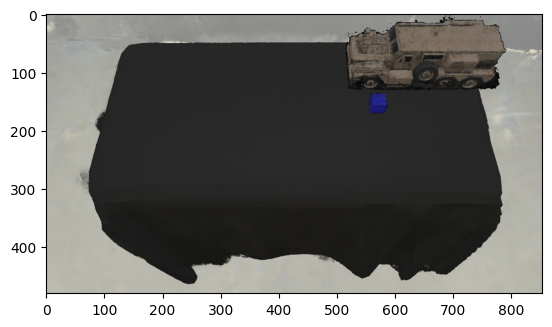

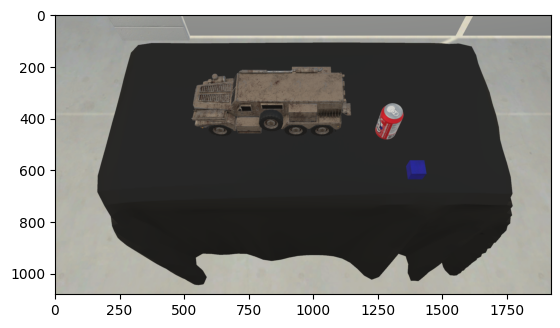

In [4]:
plt.figure()
plt.imshow(image_composed)
plt.figure()
plt.imshow(ros_image)

scale = 1.0
image_composed = cv2.resize(image_composed, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
ros_image = cv2.resize(ros_image, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC) 
tmp = np.max(depth_buffer)
depth_buffer = tmp*cv2.resize(depth_buffer/tmp, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR) 

In [5]:
sys.path.append('../unimatch_repo')

import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from evaluate_flow import inference_flow
from utils.flow_viz import flow_to_image
from PIL import Image as im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='flow').to(device)

trained_model_path = '../unimatch_repo/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_model_path, map_location=loc)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

In [6]:
import sys
sys.path.append('../unimatch_repo')
import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from dataloader.stereo import transforms
from utils.visualization import viz_depth_tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stereo = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='stereo').to(device)

trained_depth_path = '../unimatch_repo/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_depth_path, map_location=loc)
model_stereo.load_state_dict(checkpoint['model'], strict=False)
model_stereo.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

2.1230547428131104


/home/paul/CLionProjects/thesis_nerf/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


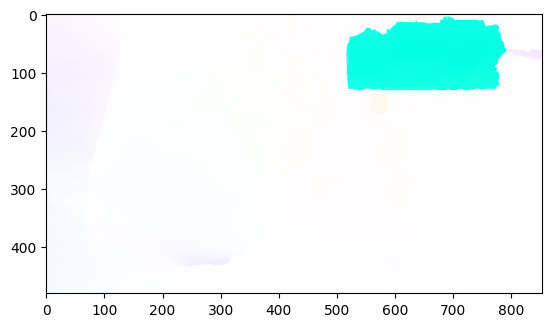

In [7]:

def get_flow(model, image1, image2): 
    padding_factor=32

    # the model is trained with size: width > height
    transpose_img = False
    if image1.size(-2) > image1.size(-1):
        image1 = torch.transpose(image1, -2, -1)
        image2 = torch.transpose(image2, -2, -1)
        transpose_img = True

    nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]
    fixed_inference_size = None
    # fixed_inference_size = [val//2 for val in nearest_size] 
#     fixed_inference_size = (224, 384)

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
    ori_size = image1.shape[-2:]

    # resize before inference
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                               align_corners=True)
        image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                               align_corners=True)


    for i in range(1):
        import time
        start = time.time()
        with torch.inference_mode():
            results_dict = model(image1, image2,
                                attn_type='swin',
                                attn_splits_list=[2, 8],
                                corr_radius_list=[-1, 4],
                                prop_radius_list=[-1, 1],
                                num_reg_refine=6,
                                task='flow'
                                )
        print(time.time() - start)


    flow_pr = results_dict['flow_preds'][-1]

    # resize back
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        flow_pr = F.interpolate(flow_pr, size=ori_size, mode='nearest') # align_corners=True
        flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
        flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

    if transpose_img:
        flow_pr = torch.transpose(flow_pr, -2, -1)

    flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]
    return flow 


image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)
    
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def get_points(depth, tf_cam_world_inv, fov, width, height):
    fx = 2*np.tan(fov/2.0)
    fy = fx*width/height
    Z = depth
    [Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, width), np.linspace(-.5, .5, height))
    X = (Xgrid)*Z/fx
    Y = (Ygrid)*Z/fy
    points = np.stack([X, Y, Z], axis=2);
    points = np.reshape(points, (-1, 3))
    points = (points @ tf_cam_world_inv[:3, :3].transpose()) + np.reshape(tf_cam_world_inv[:3, 3], (1, 3))
    
    return points

cached_render = {}
def render_nerf(testbed_map, tf_map, fov, width, height):
    all_points = []
    all_depth = []
    depth_buffer = 10000000*np.ones((height, width))
    image_composed = np.zeros((height, width, 3))
    object_inds = np.zeros((height, width), dtype=np.int32)
    
    
    for ind, obj in enumerate(testbed_map):
        testbed = testbed_map[obj]
        tf_nerf_cam = tf_map[obj]
        tf_cam_nerf = np.linalg.inv(tf_nerf_cam.detach().cpu().numpy())
        c2w = tf_cam_nerf.copy()
        c2w[0:3, 2] *= -1  # flip the y and z axis
        c2w[0:3, 1] *= -1
        c2w = c2w[[1, 0, 2, 3], :]
        c2w[2, :] *= -1  # flip whole world upside down
        tf_ngp = c2w
        tf_ngp = tf_ngp[:-1, :]
        testbed.set_nerf_camera_matrix(tf_ngp)

        if obj == 'table' and obj in cached_render:
            image, depth = cached_render[obj]
        else:
            testbed.nerf.render_min_transmittance = 0.01
            testbed.render_mode = ngp.RenderMode.Shade
            testbed.color_space = ngp.ColorSpace.Linear
            image = testbed.render(width, height, spp, True)
            testbed.nerf.render_min_transmittance = 0.9
            testbed.render_mode = ngp.RenderMode.Depth
            depth = testbed.render(width, height, spp, True)
        
        if obj == 'table' and obj not in cached_render:
            cached_render[obj] = (image, depth)
            
        depth = depth[:, :, 0]
        depth[depth < 0.1]  = 10000000
        inds = (depth < depth_buffer)
        image_composed[inds, 0] = image[inds, 0]
        image_composed[inds, 1] = image[inds, 1]
        image_composed[inds, 2] = image[inds, 2]
        depth_buffer[inds] = depth[inds]
        object_inds[inds] = ind
        
        all_depth.append(depth.flatten())
        points = get_points(depth, tf_cam_nerf, fov, width, height) 
        Rt_tensor = tf_nerf_cam[:3, :3].transpose(0, 1)
        p_tensor = tf_nerf_cam[:3, 3]
        points = torch.tensor(points, dtype=torch.float32, device='cuda', requires_grad=False)
        points_tensor = (points @ Rt_tensor) + torch.reshape(p_tensor, (1, 3)) # need grad
        all_points.append(points_tensor)
        
        
    all_points = torch.stack(all_points, axis=0)
    all_depth = torch.tensor(np.vstack(all_depth), dtype=torch.float32, device='cuda')
    min_z, inds = torch.min(all_depth, axis=0) # keepdim=True 
    
    x_vals = all_points[:, :, 0].flatten()
    y_vals = all_points[:, :, 1].flatten()
    z_vals = all_points[:, :, 2].flatten()
    
    inds = inds*inds.shape[0] + torch.linspace(0, inds.shape[0]-1, inds.shape[0], dtype=torch.int32, device='cuda')
    
    points_composed = torch.stack([x_vals[inds], y_vals[inds], z_vals[inds]], axis=1)
    image_composed = linear_to_srgb(image_composed)
    
    return points_composed, image_composed, object_inds  



def get_transform(rpy_params, xyz_params):
    rpy_params = torch.reshape(rpy_params, (3,1))
    xyz_params = torch.reshape(xyz_params, (3,1)) 
    ct = torch.cos(rpy_params);
    st = torch.sin(rpy_params);
    R00 = ct[0]*ct[2]*ct[1] - st[0]*st[2]
    R01 = -ct[0]*ct[1]*st[2] - st[0]*ct[2]
    R02 = ct[0]*st[1]
    R10 = st[0]*ct[2]*ct[1] + ct[0]*st[2]
    R11 = -st[0]*ct[1]*st[2] + ct[0]*ct[2]
    R12 = st[0]*st[1]
    R20 = -st[1]*ct[2]
    R21 = st[1]*st[2]
    R22 = ct[1]
    R0 = torch.hstack([R00, R01, R02])
    R1 = torch.hstack([R10, R11, R12])
    R2 = torch.hstack([R20, R21, R22])
    R = torch.stack([R0, R1, R2], axis=0);
        
    row = torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=torch.float32, device='cuda')
    M = torch.hstack([R, xyz_params])
    T = torch.vstack([M, row])
    return T

class CorrespondenceNet(nn.Module):
    def __init__(self, testbed_map, width, height, tf):
        super(CorrespondenceNet, self).__init__()
        self.testbed_map = testbed_map
        self.width = width
        self.height = height
        self.objects = [key for key in testbed_map.keys() ]
#         tmp = 2*3.14*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[0::3] = 0
#         tmp[1::3] = 0
#         self.rpy = nn.Parameter(tmp)
#         tmp = .25 - .5*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[2::3] = 0
#         self.xyz = nn.Parameter(tmp)
        self.fov = testbed_map['table'].fov
        assert all([testbed_map[key].fov == self.fov for key in testbed_map])
        self.fov = math.pi*self.fov/180.0
        self.tf_cam_world = torch.tensor(tf, dtype=torch.float32, device='cuda') 
        self.default_transforms = {}
        self.tf_nerf_cam = {}
        
        
        for obj in self.objects:
            T = np.linalg.inv(tf)
            self.default_transforms[obj] = torch.tensor(T, dtype=torch.float32, device='cuda')
        for obj in self.objects:
            self.reset_transform(obj)
        
        
    def reset_transform(self, obj):
        if obj == 'table':
            self.tf_nerf_cam[obj] = self.default_transforms[obj]
            return
                
        box_tf = np.eye(4,4, dtype=np.float32)
        box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
        box_tf[[0,1], 3] = box_tf[[1,0], 3]
        xyz = .25 - .5*torch.rand(3, dtype=torch.float32, device='cuda')
        xyz[2::3] = 0
        tf_trans_learned = get_transform(torch.zeros(3).to(device), xyz)
        rpy = 2*3.14*torch.rand(3, dtype=torch.float32, device='cuda')
        rpy[0::3] = 0
        rpy[1::3] = 0
        tf_rot_learned = get_transform(rpy, torch.zeros(3).to(device))
        box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
        box_tf = torch.from_numpy(box_tf).to(device)

        default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
                                        [ 0.0000,  1.0, 0, 0],
                                        [-0.0000, 0, -1.0,  0],
                                        [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
        default_transform[0,3] += box_tf[0,3]
        default_transform[1,3] += box_tf[1,3]
        default_transform[2,3] += box_tf[2,3] + 0.8
        default_transform = torch.linalg.inv(default_transform)

        tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
        tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
        self.tf_nerf_cam[obj] = tf_nerf_cam 
                
        
    def forward(self):
        tf_map = {}
        ind = 0
        for obj in self.objects:
#             default_transform = self.default_transforms[obj]
#             if obj != 'table':
#                 box_tf = np.eye(4,4, dtype=np.float32)
#                 box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
#                 box_tf[[0,1], 3] = box_tf[[1,0], 3]
                
#                 tf_trans_learned = get_transform(torch.zeros(3).to(device), self.xyz[(ind)*3:(ind+1)*3])
#                 tf_rot_learned = get_transform(self.rpy[(ind)*3:(ind+1)*3], torch.zeros(3).to(device))
#                 box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
#                 box_tf = torch.from_numpy(box_tf).to(device)
                
#                 default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
#                                                 [ 0.0000,  1.0, 0, 0],
#                                                 [-0.0000, 0, -1.0,  0],
#                                                 [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
#                 default_transform[0,3] += box_tf[0,3]
#                 default_transform[1,3] += box_tf[1,3]
#                 default_transform[2,3] += box_tf[2,3] + 0.8
#                 default_transform = torch.linalg.inv(default_transform)

#                 tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
#                 tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
                
#                 ind += 1
#             else:
#                 tf_nerf_cam = default_transform
            tf_map[obj] = self.tf_nerf_cam[obj]
            
        points_composed, image_composed, object_inds = render_nerf(self.testbed_map, tf_map, self.fov, self.width, self.height)
        
        Rt = self.tf_cam_world[:3, :3].transpose(0,1)
        points_composed_world = (points_composed @ Rt) + torch.reshape(self.tf_cam_world[:3, 3], (1, 3)) 
        x = points_composed[:, 0]/points_composed[:, 2];
        y = points_composed[:, 1]/points_composed[:, 2];
        points_2d = torch.stack([x, y], axis=1)
        
        return points_composed, points_composed_world, points_2d, image_composed, object_inds

def compute_loss(pred_points, target_points, uv, target_grid):
    loss = F.huber_loss(pred_points, target_points)
    return loss
    
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
ros_image = ros_image[0]
tf = tf[0]
network = CorrespondenceNet(testbed_map, width, height, tf)
network.cuda(device='cuda')



[WARN] [1697567334.613643771] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


CorrespondenceNet()

14:28:54 DEBUG    GPUMemoryArena: enlarging from 292 MB to 299 MB


[WARN] [1697567335.110029757] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


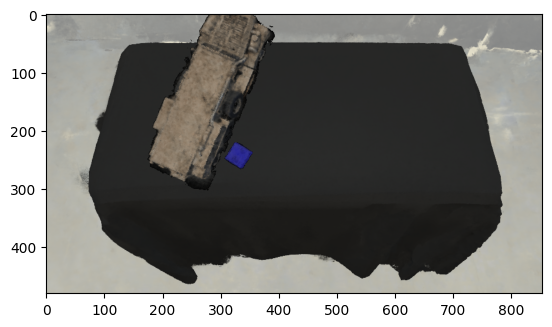

In [9]:
points_composed, points_composed_world, points_2d, image_composed, object_inds = network()
plt.figure()
plt.imshow(image_composed)
colors = np.reshape(image_composed, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)

# tmp = np.ones(points_composed_world.shape)
# tmp[:, :2] = points_2d.detach().cpu().numpy()
# send_point_cloud(np.hstack((tmp, colors)), has_alpha=False, topic='point_cloud_2')
# print(torch.max(points_2d))

0.11356377601623535


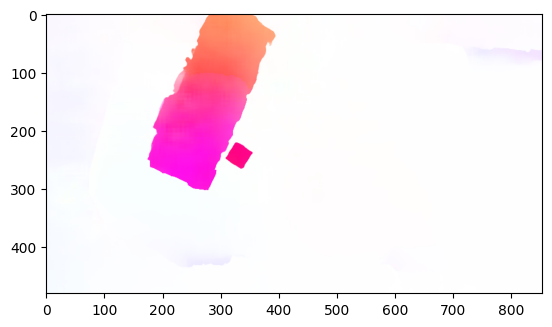

In [10]:
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

[544, 960]


[WARN] [1697567337.137283383] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


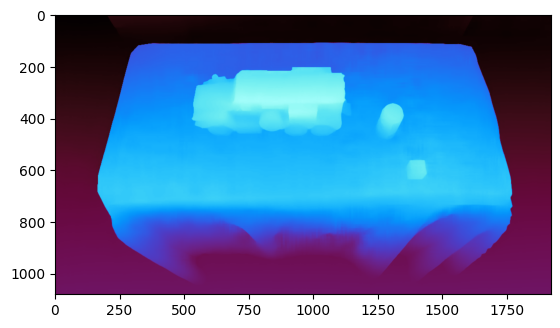

In [11]:
from utils.visualization import vis_disparity

def get_disparity(model_stereo, left, right):
    padding_factor = 32
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]


    sample = {'left': left,
              'right': right
              }
    val_transform_list = [transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
    val_transform = transforms.Compose(val_transform_list)
    sample = val_transform(sample)
    left = sample['left'].to(device).unsqueeze(0)  # [1, 3, H, W]
    right = sample['right'].to(device).unsqueeze(0)  # [1, 3, H, W]

    nearest_size = [int(np.ceil(left.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(left.size(-1) / padding_factor)) * padding_factor]

    fixed_inference_size = [val//2 for val in nearest_size] 
    print(fixed_inference_size)
#     fixed_inference_size = [288, 480]
#     fixed_inference_size = None

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    ori_size = left.shape[-2:]

    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        left = F.interpolate(left, size=inference_size,
                             mode='bilinear',
                             align_corners=True)
        right = F.interpolate(right, size=inference_size,
                              mode='bilinear',
                                  align_corners=True)

    with torch.no_grad():
        import time
        for i  in range(1):
            start = time.time()
            pred_disp = model_stereo(left, right,
                               attn_type='self_swin2d_cross_swin1d',
                               attn_splits_list=[2, 8],
                               prop_radius_list=[-1, 1],
                               corr_radius_list=[-1, 4],
                               num_reg_refine=3,
                               task='stereo',
                               )['flow_preds'][-1]  # [1, H, W]
#             print(time.time() - start)



    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        pred_disp = F.interpolate(pred_disp.unsqueeze(1), size=ori_size, mode='nearest').squeeze(1)  # [1, H, W]


    disp = pred_disp[0].cpu().numpy()
    return disp 



left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
left_pose = left_pose[0]
left = left[0]

right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
right_pose = right_pose[0]
right = right[0]



left = left[:,:,:3].astype(np.float32)
left_ori = left.copy() 
right = right[:,:,:3].astype(np.float32)

disp = get_disparity(model_stereo, left, right)

plt.figure()
plt.imshow(vis_disparity(disp))


In [12]:
def get_points_from_disparity(disp, left_pose, right_pose):
    baseline = np.sqrt(np.sum((left_pose[:3,3]-right_pose[:3,3])**2))
    fov = 69.4*(math.pi/180.0)
    focal = 2*np.tan(fov/2.0)
    depth = baseline * focal / disp
    depth = depth/2.0 # correct for scaling

    points = 1000*get_points(depth, np.eye(4), math.pi*(42.5/180.0), depth.shape[1], depth.shape[0])
    Rt = left_pose[:3, :3].transpose(0,1)
    points = (points @ Rt) + np.reshape(left_pose[:3, 3], (1, 3)) 
    return points 

stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
tmp = left_ori/255
tmp[tmp>1.0] = 1.0

stereo_colors = np.reshape(tmp, (-1, 3))
stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])
send_point_cloud(np.hstack((stereo_points, stereo_colors)), has_alpha=False)




In [ ]:
from torch.nn.functional import grid_sample 
import cvxpy as cp
from qpsolvers import solve_qp
import time

def send_obj_tf(obj):
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)

def update_tf(obj, T):
    T_tensor = torch.from_numpy(T).to(device)
    T_new = torch.inverse(network.tf_cam_world) @ T_tensor @ network.tf_cam_world @ network.tf_nerf_cam[obj]
    network.tf_nerf_cam[obj] = T_new 

def calc_transform(object_points, target_object_points):
    A = object_points
    B = target_object_points

    centriodA = np.reshape(np.mean(A, axis=1), (3,1))
    centriodB = np.reshape(np.mean(B, axis=1), (3,1))

    H = (A-centriodA)@(B-centriodB).transpose()
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[2,:] *= -1
        R = Vt.T @ U.T
        assert np.linalg.det(R) > 0
    
    P = centriodB - R@centriodA
    
    return R, P

    
    
while True:
    # def find_matches():

    left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
    left_pose = left_pose[0]
    left = left[0]
    image2 = left[:,:,:3]
    image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)
    left = left[:,:,:3].astype(np.float32)
    stereo_colors = np.reshape(left/255, (-1, 3))
    stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])

    right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
    right_pose = right_pose[0]
    right = right[0]
    right = right[:,:,:3].astype(np.float32)
    start = time.time()
    disp = get_disparity(model_stereo, left, right)
    stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
    print(time.time()-start)
    
    grid_points = np.reshape(stereo_points, (disp.shape[0], disp.shape[1], 3))
    grid_points = torch.from_numpy(grid_points)

    find_objects = {'block':2, 'truck':1}
    object_points_map = {}    
    
    for it2 in range(1):     
        points_composed, points_composed_world, points_2d, image_composed, object_inds = network()    

        image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
        image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
        flow = get_flow(model, image1, image2)
        grid_flow = np.reshape(flow, (image_composed.shape[0], image_composed.shape[1], 2))
        grid_flow[:,:,0] = 2*grid_flow[:,:,0]/image_composed.shape[1]
        grid_flow[:,:,1] = 2*grid_flow[:,:,1]/image_composed.shape[0]
        grid_flow_mag = np.sqrt(np.sum(grid_flow**2, axis=2))

        [Xgrid, Ygrid] = np.meshgrid(np.linspace(-1.0, 1.0, image_composed.shape[1]), np.linspace(-1.0, 1.0, image_composed.shape[0]))
        grid_base  = np.stack([Xgrid, Ygrid], axis=2);
        grid_input = grid_base + grid_flow 
        grid_input = torch.from_numpy(grid_input)


        target_points = grid_sample(grid_points.transpose(0, 2).transpose(1, 2).unsqueeze(axis=0), grid_input.unsqueeze(axis=0), mode='nearest', padding_mode='border') # align_corners=None
        target_points = torch.reshape(target_points,(3, -1))
        target_points = target_points.transpose(0,1)
        target_points = target_points.to(device)


        objs = [v for v in find_objects.keys()]
        for obj in objs:
            obj_ind = find_objects[obj]
            object_points = points_composed_world[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            target_object_points = target_points[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            R = np.eye(3, 3, dtype=np.float32)
            P = np.zeros((3, 1), dtype=np.float32)
            T = np.eye(4,4, dtype=np.float32)
            num_points = 10

#             num_hits = 0
#             best_quality = 999999999999999999.0
            for attempt in range(20):
                if object_points.shape[0] < num_points:
                    break
#                 if num_hits >= 5:
#                     break
        
                inds = np.random.choice(object_points.shape[0], num_points, replace=False)
                
                R, P = calc_transform(object_points[inds, :].transpose(), target_object_points[inds, :].transpose())
            
                matched_points = (object_points @ R.transpose()) + np.reshape(P, (1, 3)) 
                quality = np.sqrt( np.sum( (matched_points-target_object_points)**2,axis=1) )
                quality_inds = np.argsort(quality)
                quality_inds = quality_inds[:(len(quality_inds)*5)//10]
                quality = quality[quality_inds]
                quality = np.max(quality)

                if quality > 0.02: # 0.025 is ideal
                    continue
                else:
                    sub_inds = np.linspace(0, len(quality_inds)-1, 100, dtype=np.int32)
                    quality_inds = quality_inds[sub_inds]
                
                    R, P = calc_transform(object_points[quality_inds, :].transpose(), target_object_points[quality_inds, :].transpose())
            
#                     num_hits += 1
                    print(quality)
#                     if quality < best_quality:
#                         best_quality = quality
                    print(f'found match: {obj}!')
                    object_points_map[obj] = object_points
                    T[:3, :3] = R
                    T[:3, 3] = P.flatten()
                    update_tf(obj, T)
                    find_objects.pop(obj)
                    break
                
        for obj in ['truck', 'block']:
            send_obj_tf(obj)
                    
        for obj in find_objects:
            network.reset_transform(obj)
        if len(find_objects)==0:
            break
        print(f'iter: {it2}')

    if len(find_objects)>=0:
        pass
#         colors = np.reshape(image_composed, (-1, 3))
#         colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
#         colors = colors[np.reshape(object_inds == 1, (-1,)), :]
#         colors[:,:3] = colors[:,:3]*.2
#         colors[:, 1] = 1
#         matched_points = (object_points_map['truck'] @ R.transpose()) + np.reshape(P, (1, 3)) 
#         vals = np.hstack((matched_points, colors))
#         send_point_cloud(vals, has_alpha=False, topic='point_cloud_2')

        points_composed, points_composed_world, points_2d, image_composed_innner, object_inds = network()    
        colors = np.reshape(image_composed_innner, (-1, 3))
        colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
        send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)


# import cProfile
# cProfile.run("find_matches()")

print(quality)
print(attempt)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)



[WARN] [1697567341.923598565] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1953732967376709
0.11346673965454102
0.014951255949795605
found match: block!
iter: 0


/home/paul/CLionProjects/thesis_nerf/venv/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
[WARN] [1697567342.557200542] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567344.485443233] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with tha

[544, 960]
0.19335484504699707
0.11367368698120117
0.008654620258863259
found match: block!
iter: 0


[WARN] [1697567345.129783042] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567347.026849350] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19204926490783691
0.1127016544342041
0.006418702644583973
found match: block!
iter: 0


[WARN] [1697567347.627259859] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567349.552747004] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19887065887451172
0.11374115943908691
0.009203075842160612
found match: block!
iter: 0


[WARN] [1697567350.210909131] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567353.210156024] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16607427597045898
0.12734055519104004
0.007467502573772397
found match: block!
iter: 0


[WARN] [1697567355.678782192] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1763474941253662
0.1216270923614502
0.01006026306936858
found match: block!
iter: 0


[WARN] [1697567356.270509801] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567358.177249834] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19949984550476074
0.1170816421508789
iter: 0


[WARN] [1697567358.845437135] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567360.766161085] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1803452968597412
0.1320326328277588
0.008320901860173003
found match: block!
iter: 0


[WARN] [1697567363.244022990] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19475507736206055
0.12233877182006836
0.006514829244070142
found match: block!
0.008586361019857658
found match: truck!


[WARN] [1697567363.835988199] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567365.768615397] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19722414016723633
0.11999225616455078
0.007070151245842694
found match: block!
0.011296975307085746
found match: truck!


[WARN] [1697567366.341739326] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19952893257141113
0.11310386657714844
0.010440217132192267
found match: block!
0.008877846539858967
found match: truck!


[WARN] [1697567368.847398195] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567370.734400402] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19040822982788086
0.1336214542388916
0.008395794213487726
found match: block!
0.010528469171147938
found match: truck!


[WARN] [1697567371.304821291] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567373.262140453] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3133430480957031
0.11594867706298828
0.005673033646965411
found match: block!
0.009255900016668846
found match: truck!


[WARN] [1697567376.054586172] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20544171333312988
0.11526083946228027
0.0026979825667644477
found match: block!
0.01413764498969649
found match: truck!


[WARN] [1697567376.705691166] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567378.566514017] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31067967414855957
0.11638736724853516
0.0028288134221713785
found match: block!
0.009742654550807438
found match: truck!


[WARN] [1697567379.362452556] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567381.318965011] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3249795436859131
0.11857104301452637
0.006440653017989318
found match: block!
0.009375361655120922
found match: truck!


[WARN] [1697567384.129898973] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22579717636108398
0.11504411697387695
0.004484549379566783
found match: block!
0.010044922882052014
found match: truck!


[WARN] [1697567384.884096669] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567386.801399577] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.33220982551574707
0.10891962051391602
0.004643558596447291
found match: block!
0.00858502230130119
found match: truck!


[WARN] [1697567387.579320668] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567389.572634286] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.29509949684143066
0.11403417587280273
0.004067737856053323
found match: block!
0.013145906790323902
found match: truck!


[WARN] [1697567392.556067119] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2742130756378174
0.1130666732788086
0.006987582004089369
found match: block!
0.008773717776062472
found match: truck!


[WARN] [1697567393.349071787] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567395.336968447] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.24018049240112305
0.11000490188598633
0.006040380567499576
found match: block!
0.011640950645452073
found match: truck!


[WARN] [1697567396.043172993] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2957038879394531
0.11723208427429199
0.00606336308577941
found match: block!
0.010068321099750777
found match: truck!


[WARN] [1697567398.776452123] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567401.045326908] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.27297377586364746
0.11219263076782227
0.006946961485625222
found match: block!
0.011238694477868466
found match: truck!


[WARN] [1697567401.905029323] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567403.901946284] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3232271671295166
0.11156225204467773
0.006100033145204253
found match: block!
0.008758433659680053
found match: truck!


[WARN] [1697567406.942242395] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3623795509338379
0.12900209426879883
0.008019369143204712
found match: block!
0.008706596129738927
found match: truck!


[WARN] [1697567407.887020455] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567409.953154087] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3495020866394043
0.11085700988769531
0.007597608919295949
found match: block!
0.009158808601894068
found match: truck!


[WARN] [1697567410.981636095] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567413.021433796] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31836915016174316
0.12117981910705566
0.005697652581167057
found match: block!
0.011089670935995596
found match: truck!


[WARN] [1697567415.847636147] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3478372097015381
0.11331653594970703
0.009483643787282834
found match: block!
0.01373450237961578
found match: truck!


[WARN] [1697567416.728707848] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567418.757539641] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3053555488586426
0.13403892517089844
0.004220011524655178
found match: block!
0.009791009998262608
found match: truck!


[WARN] [1697567419.530116344] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.33396482467651367
0.11190128326416016
iter: 0


[WARN] [1697567422.557678603] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567424.670653916] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2874634265899658
0.1136162281036377
iter: 0


[WARN] [1697567425.674621093] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567427.776276611] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2840745449066162
0.12040066719055176
iter: 0


[WARN] [1697567430.816923492] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31937313079833984
0.11404132843017578
iter: 0


[WARN] [1697567431.774266261] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567433.863400019] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2910501956939697
0.13090753555297852
iter: 0


[WARN] [1697567434.798222251] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567436.931471201] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3158235549926758
0.10935091972351074
iter: 0


[WARN] [1697567439.978800371] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2276623249053955
0.1215817928314209
iter: 0


[WARN] [1697567440.836048381] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567442.940713124] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31159186363220215
0.11548614501953125
iter: 0


[WARN] [1697567443.955986902] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


14:30:44 DEBUG    GPUMemoryArena: enlarging from 300 MB to 301 MB


[WARN] [1697567446.138088346] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1780557632446289
0.12265825271606445
iter: 0


[WARN] [1697567448.758208791] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1762852668762207
0.10825562477111816
iter: 0


[WARN] [1697567449.353266114] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567451.296601029] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17159819602966309
0.11110401153564453
iter: 0


[WARN] [1697567452.014414369] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17795348167419434
0.12133502960205078
iter: 0


[WARN] [1697567454.603047308] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567456.534728440] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1703639030456543
0.11446785926818848
0.0033886725508624977
found match: block!
0.012365557848161726
found match: truck!


[WARN] [1697567457.146661059] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567458.990821184] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16920876502990723
0.1257617473602295
0.006494012069589335
found match: block!
0.009059653272919034
found match: truck!


[WARN] [1697567461.511831040] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1725618839263916
0.11083221435546875
0.004136148308882065
found match: block!
0.010169769967786445
found match: truck!


[WARN] [1697567462.083435475] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567464.041657707] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17557120323181152
0.12205624580383301
0.0032827144099419002
found match: block!
0.008995150645681193
found match: truck!


[WARN] [1697567464.649064239] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567466.588237669] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17183423042297363
0.12382841110229492
0.00482686396078331
found match: block!
0.011397307537416303
found match: truck!


[WARN] [1697567469.099113942] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17055559158325195
0.13280701637268066
0.00884396385455659
found match: block!
0.017352081002065575
found match: truck!


[WARN] [1697567469.724377630] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567471.641418593] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17391276359558105
0.13349175453186035
0.0063441516547935155
found match: block!
0.018596907341200158
found match: truck!


[WARN] [1697567472.251439228] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567475.195159185] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17079901695251465
0.10591912269592285
0.0028169257966679227
found match: block!
0.008603212793992255
found match: truck!


[WARN] [1697567480.492610290] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1713852882385254
0.10717177391052246
0.004280428125252316
found match: block!
0.010599034862594912
found match: truck!


[WARN] [1697567481.991290488] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567483.942556232] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17231535911560059
0.11203885078430176
0.006354861939263282
found match: block!
0.011358483501367918
found match: truck!


[WARN] [1697567484.631986979] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1737508773803711
0.10774779319763184
0.002651624590217358
found match: block!
0.009042034624986917
found match: truck!


[WARN] [1697567487.628613314] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567489.902557067] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16634798049926758
0.12179040908813477
0.008719732039382432
found match: block!
0.010698099743881377
found match: truck!


[WARN] [1697567490.546245264] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567492.541025872] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18739867210388184
0.11902451515197754
0.009775514142886896
found match: block!
0.009372979054523695
found match: truck!


[WARN] [1697567495.303975299] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17423033714294434
0.12280869483947754
0.003203293330362506
found match: block!
0.011187868030774387
found match: truck!


[WARN] [1697567495.983600607] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567498.240355405] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16916871070861816
0.12047648429870605
0.002850262878465166
found match: block!
0.009047162448791772
found match: truck!


[WARN] [1697567499.022125150] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567501.346069149] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18347501754760742
0.11572885513305664
0.005179700942657327
found match: block!
0.008762331665547138
found match: truck!


[WARN] [1697567503.944032226] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1697521209716797
0.12930703163146973
0.005360271195191076
found match: block!
0.010042918481586595
found match: truck!


[WARN] [1697567504.743183294] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567506.739177851] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1730353832244873
0.12602734565734863
0.005977088561282524
found match: block!
0.01024102427694288
found match: truck!


[WARN] [1697567507.379080375] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567509.664599833] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1675252914428711
0.121185302734375
0.0026056496086540168
found match: block!
0.009002331756429794
found match: truck!


[WARN] [1697567512.584661467] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1758100986480713
0.11275029182434082
0.0025298601216195444
found match: block!
0.01163272377597738
found match: truck!


[WARN] [1697567513.259923107] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567515.300434246] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.240983247756958
0.11165761947631836
0.0068104928393498574
found match: block!
0.015216136769777544
found match: truck!


[WARN] [1697567516.052033249] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2246699333190918
0.11143112182617188
0.009794214729558822
found match: block!
0.009075947910734112
found match: truck!


[WARN] [1697567518.986394444] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567521.009549318] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2817065715789795
0.11166262626647949
0.0040857004034817205
found match: block!
0.009849305063896332
found match: truck!


[WARN] [1697567521.945942407] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567523.985622909] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.34943580627441406
0.11101531982421875
0.0032790187461535004
found match: block!
0.009137561077384716
found match: truck!


[WARN] [1697567527.319285465] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2834205627441406
0.11021232604980469
0.010567497158574957
found match: block!
0.010828487384684232
found match: truck!


[WARN] [1697567528.128968087] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567530.165049518] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.28116369247436523
0.12480854988098145
0.003070000293363084
found match: block!
0.010910845058034887
found match: truck!


[WARN] [1697567531.129315553] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567533.343068347] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3905372619628906
0.12178277969360352
0.0039807739690256964
found match: block!
0.011395474484516208
found match: truck!


[WARN] [1697567536.528937080] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.43579840660095215
0.11660218238830566
0.002962927410722259
found match: block!
0.01863021103633704
found match: truck!


[WARN] [1697567537.467139934] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567539.563805216] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3030521869659424
0.11273646354675293
0.008790099568781087
found match: block!
0.009213590551133525
found match: truck!


[WARN] [1697567540.560883149] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567542.666437731] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1737375259399414
0.11290311813354492
0.0035387065157480913
found match: block!
0.011533948666330231
found match: truck!


[WARN] [1697567545.318994236] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16280913352966309
0.14774608612060547
0.004842961209559633
found match: block!
0.01857874687989578
found match: truck!


[WARN] [1697567546.315650852] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567548.241434150] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1756000518798828
0.11965513229370117
0.0023881681601717586
found match: block!
0.01007215379745889
found match: truck!


[WARN] [1697567548.859877238] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1721630096435547
0.12284278869628906
0.002225496957528109
found match: block!
0.014558659375295933
found match: truck!


[WARN] [1697567551.337923616] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567553.102264231] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1747884750366211
0.11902093887329102
0.0026809794674608474
found match: block!
0.009109120725230716
found match: truck!


[WARN] [1697567553.769161169] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567555.713334132] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1762681007385254
0.13680219650268555
0.00367090233669832
found match: block!
0.009453029633418477
found match: truck!


[WARN] [1697567558.246092341] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1773209571838379
0.12079858779907227
0.0031586088396974754
found match: block!
0.009701537080942063
found match: truck!


[WARN] [1697567558.875848455] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567560.820673902] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17299485206604004
0.11223912239074707
0.001841343978078509
found match: block!
0.009497300747717808
found match: truck!


[WARN] [1697567561.470256289] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567563.369809771] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17635273933410645
0.11246204376220703
0.0032232090929917244
found match: block!
0.008852523891975978
found match: truck!


[WARN] [1697567566.188997586] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17450594902038574
0.11723041534423828
0.006877217977413784
found match: block!
0.010365151172398276
found match: truck!


[WARN] [1697567567.040827609] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567569.035841625] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17571282386779785
0.12183904647827148
0.0025885211848636954
found match: block!
0.010137944345198432
found match: truck!


[WARN] [1697567569.660945424] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567571.655097711] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1725142002105713
0.1102592945098877
0.006811737447334556
found match: block!
0.010848389348790758
found match: truck!


[WARN] [1697567574.621675584] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17671728134155273
0.11838126182556152
0.003955178900252503
found match: block!
0.01145306463013249
found match: truck!


[WARN] [1697567575.284664200] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567577.272584040] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17624282836914062
0.11047983169555664
0.009992942049922935
found match: block!
0.008715295836885994
found match: truck!


[WARN] [1697567577.965765007] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17376112937927246
0.11381340026855469
0.0029679759201296373
found match: block!
0.014089225114087918
found match: truck!


[WARN] [1697567580.623334868] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567582.641691908] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17649245262145996
0.12465620040893555
0.002959378951880034
found match: block!
0.009903964842811521
found match: truck!


[WARN] [1697567583.314110203] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567585.311387661] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19743871688842773
0.11257266998291016
0.006703336579420633
found match: block!
0.01070822737765042
found match: truck!


[WARN] [1697567588.021759378] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1870875358581543
0.11343574523925781
0.0027278480299710293
found match: block!
0.008800540427781407
found match: truck!


[WARN] [1697567588.801484331] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567591.136563795] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18527483940124512
0.11253547668457031
0.0018959413782534242
found match: block!
0.009440460995057357
found match: truck!


[WARN] [1697567591.835619083] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567593.900955227] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17476701736450195
0.11567234992980957
0.005885120605821645
found match: block!
0.010724493369945505
found match: truck!


[WARN] [1697567596.887164925] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1763603687286377
0.11394834518432617
0.007118069712635882
found match: block!
0.010623758771091335
found match: truck!


[WARN] [1697567597.644475351] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567599.605666531] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1747443675994873
0.12519550323486328
0.0022930297079363656
found match: block!
0.00888787018984843
found match: truck!


[WARN] [1697567600.311745781] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567602.283670974] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17241978645324707
0.1164705753326416
0.00751828059615927
found match: block!
0.012181895994487144
found match: truck!


[WARN] [1697567605.096755998] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17855143547058105
0.11513662338256836
0.0031837857271980207
found match: block!
0.00907320016020384
found match: truck!


[WARN] [1697567605.839214816] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567607.787502699] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1791529655456543
0.12320089340209961
0.011581054693872482
found match: block!
0.008892121596958352
found match: truck!


[WARN] [1697567608.559659803] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1729738712310791
0.12409853935241699
0.0034020148747289152
found match: block!
0.009129659022754803
found match: truck!


[WARN] [1697567611.391137281] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567613.526527188] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.30318570137023926
0.11441469192504883
0.003607657860542073
found match: block!
0.010823563422096923
found match: truck!


[WARN] [1697567614.460452164] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567616.410387987] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3390986919403076
0.12057161331176758
0.0040814860591611565
found match: block!
0.008890557912703738
found match: truck!


[WARN] [1697567619.416752810] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2863616943359375
0.11354827880859375
0.004417450153003366
found match: block!
0.009790577524901284
found match: truck!


[WARN] [1697567620.358734329] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567622.536008093] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.322986364364624
0.11287307739257812
0.002801260337932158
found match: block!
0.008838628513721131
found match: truck!


[WARN] [1697567623.527961379] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567625.752993422] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3445322513580322
0.1138758659362793
0.005750824374746003
found match: block!
0.011044087724651739
found match: truck!


[WARN] [1697567628.815420101] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.34697914123535156
0.11978602409362793
0.0026769073858956684
found match: block!
0.009371750841725746
found match: truck!


[WARN] [1697567629.810651822] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567631.963120932] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3746788501739502
0.11524224281311035
0.007963611620974309
found match: block!
0.009605934643745494
found match: truck!


[WARN] [1697567633.214280109] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567635.412558555] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17853569984436035
0.11525630950927734
0.0023826763025900505
found match: block!
0.00903355244186763
found match: truck!


[WARN] [1697567638.065479158] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18698716163635254
0.11821222305297852
0.002989244232054822
found match: block!
0.013347453307120281
found match: truck!


[WARN] [1697567638.755743727] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567640.722828638] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17739009857177734
0.11225438117980957
0.001805224211639512
found match: block!
0.009906080304052108
found match: truck!


[WARN] [1697567641.453078177] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1774442195892334
0.11062502861022949
0.0058194641775079076
found match: block!
0.011300768836919679
found match: truck!


[WARN] [1697567643.976539450] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567645.845409809] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17731261253356934
0.12018179893493652
0.0017663174625699636
found match: block!
0.008614403457319173
found match: truck!


[WARN] [1697567646.555851913] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567648.622150813] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18384695053100586
0.11506795883178711
0.002519109923945781
found match: block!
0.009122016615326242
found match: truck!


[WARN] [1697567651.243840357] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18122172355651855
0.11391258239746094
0.0038996388268938468
found match: block!
0.012645328619362748
found match: truck!


[WARN] [1697567651.938050490] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567653.883748741] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18085265159606934
0.11525487899780273
0.0039582044964354135
found match: block!
0.008697338572243215
found match: truck!


[WARN] [1697567654.561650305] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567656.558078702] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18075990676879883
0.11758089065551758
0.007938688203724719
found match: block!
0.013127581050327653
found match: truck!


[WARN] [1697567659.393550134] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19111084938049316
0.11625862121582031
0.0024050841127395807
found match: block!
0.009263261272221053
found match: truck!


[WARN] [1697567660.274724193] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567662.230939573] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18294095993041992
0.1271953582763672
0.00549506592049725
found match: block!
0.01952106205047309
found match: truck!


[WARN] [1697567663.011668271] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567665.003361349] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18282198905944824
0.12146329879760742
0.0065867249342200975
found match: block!
0.010691652575655502
found match: truck!


[WARN] [1697567667.868219046] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1810448169708252
0.11425065994262695
0.003185299652233955
found match: block!
0.011087902721103297
found match: truck!


[WARN] [1697567668.563146817] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567670.505951244] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17250657081604004
0.11825180053710938
0.003527713535411912
found match: block!
0.013047956231636685
found match: truck!


[WARN] [1697567671.210593426] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17863821983337402
0.13826370239257812
0.0037881438800897913
found match: block!
0.01059434787850844
found match: truck!


[WARN] [1697567673.845276046] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567676.006952489] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1791994571685791
0.13292717933654785
0.009294772719047157
found match: block!
0.016146694131946547
found match: truck!


[WARN] [1697567676.667082758] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567678.862475729] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20080041885375977
0.11530113220214844
0.0039294044691901425
found match: block!
0.009344396197724944
found match: truck!


[WARN] [1697567681.651382836] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18593859672546387
0.11843013763427734
0.003919134567102441
found match: block!
0.010124570443008286
found match: truck!


[WARN] [1697567682.749866518] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567684.826141711] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19103693962097168
0.14070725440979004
0.0041899498473604345
found match: block!
0.008864430062677644
found match: truck!


[WARN] [1697567685.854045123] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567688.095525806] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18634939193725586
0.11539983749389648
0.0039035450694666143
found match: block!
0.008802171586321551
found match: truck!


[WARN] [1697567690.959321304] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1992032527923584
0.12852978706359863
0.008608215646689437
found match: block!
0.00986168114138944
found match: truck!


[WARN] [1697567691.947641996] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567694.077656032] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18990612030029297
0.12135815620422363
0.0029672799982133394
found match: block!
0.009851957713314288
found match: truck!


[WARN] [1697567694.907151097] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567697.050987446] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18962430953979492
0.12151837348937988
0.009103818293317618
found match: block!
0.010200716449708892
found match: truck!


[WARN] [1697567700.044892858] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19968318939208984
0.1315760612487793
0.00501180329925592
found match: block!
0.012134009371147874
found match: truck!


[WARN] [1697567700.877529371] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567702.914302936] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1866469383239746
0.11566519737243652
0.006474958795525412
found match: block!
0.008971329243348525
found match: truck!


[WARN] [1697567703.612046798] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19420409202575684
0.12071418762207031
0.005190840367011122
found match: block!
0.009571732847327532
found match: truck!


[WARN] [1697567706.545367103] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567708.565245687] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18279814720153809
0.11766338348388672
0.005117045508468919
found match: block!
0.010178304460880012
found match: truck!


[WARN] [1697567709.572374876] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567711.524915532] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.28406763076782227
0.1256394386291504
0.003980580987725886
found match: block!
0.009415176166914866
found match: truck!


[WARN] [1697567714.462487801] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21203827857971191
0.1270430088043213
0.007635493971690252
found match: block!
0.01212598224659979
found match: truck!


[WARN] [1697567715.312211144] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567717.357055643] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.37854623794555664
0.12556934356689453
0.004691453153108636
found match: block!
0.010201523168245708
found match: truck!


[WARN] [1697567718.687946259] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567720.894828227] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3374629020690918
0.11612796783447266
0.004154668301438639
found match: block!
0.008994289399560611
found match: truck!


[WARN] [1697567724.215387354] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.30458521842956543
0.11387300491333008
0.002286320288341451
found match: block!
0.008689086400897548
found match: truck!


[WARN] [1697567725.193417359] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567727.331596773] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.38670969009399414
0.11718869209289551
0.002554433224979491
found match: block!
0.012337451643899388
found match: truck!


[WARN] [1697567728.561078601] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567730.709402065] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17324423789978027
0.11769819259643555
0.006121824239973892
found match: block!
0.011986469657018614
found match: truck!


[WARN] [1697567733.546207581] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17828106880187988
0.1195838451385498
0.0022308200796361467
found match: block!
0.00890393028796215
found match: truck!


[WARN] [1697567734.199474642] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567736.174602378] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18997812271118164
0.11419463157653809
0.004419307158907528
found match: block!
0.009247035133309081
found match: truck!


[WARN] [1697567736.865953771] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18239760398864746
0.11886239051818848
0.004993331797675259
found match: block!
0.009950788999176605
found match: truck!


[WARN] [1697567739.470844666] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567741.478162022] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18122410774230957
0.11866378784179688
0.002604002354995696
found match: block!
0.008693860244548761
found match: truck!


[WARN] [1697567742.198786042] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567744.162420197] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2840542793273926
0.11376047134399414
0.0038322697708454744
found match: block!
0.009091890878568374
found match: truck!


[WARN] [1697567747.044628794] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17775845527648926
0.12008333206176758
0.004378084851047387
found match: block!
0.01270207199394256
found match: truck!


[WARN] [1697567747.670363564] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567749.595065006] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18082857131958008
0.12271499633789062
0.003897799108828088
found match: block!
0.009649106438322936
found match: truck!


[WARN] [1697567750.276261115] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567752.277100162] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18127846717834473
0.13643717765808105
0.005032153939797053
found match: block!
0.011140554275605355
found match: truck!


[WARN] [1697567754.915483524] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18014860153198242
0.1262061595916748
0.005080954074937136
found match: block!
0.0089378961153639
found match: truck!


[WARN] [1697567755.646217465] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567757.665198777] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18044710159301758
0.11485934257507324
0.005022115167113575
found match: block!
iter: 0


[WARN] [1697567758.853353535] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567760.907290778] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18307733535766602
0.11697030067443848
0.00782325349456704
found match: block!
iter: 0


[WARN] [1697567764.196981240] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17762184143066406
0.11676478385925293
0.005837380579204082
found match: block!
0.010939041339441485
found match: truck!


[WARN] [1697567764.943493809] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567767.014887355] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17740631103515625
0.12430238723754883
0.004300892956572109
found match: block!
0.013086338980072157
found match: truck!


[WARN] [1697567767.741692710] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18135404586791992
0.1328723430633545
0.002993463176764519
found match: block!
0.013766332070493338
found match: truck!


[WARN] [1697567770.410542191] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567772.428648288] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.198333740234375
0.11140298843383789
0.00234508016440715
found match: block!
0.01065055807575788
found match: truck!


[WARN] [1697567773.177133683] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567775.209550857] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.24168634414672852
0.12011075019836426
0.004314834232330167
found match: block!
0.010947930492739942
found match: truck!


[WARN] [1697567778.112352096] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17936229705810547
0.12955975532531738
0.003007004224252537
found match: block!
0.009142984665063523
found match: truck!


[WARN] [1697567778.821109384] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567780.791407839] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18477344512939453
0.11077594757080078
0.00607728310850011
found match: block!
0.009357670774811913
found match: truck!


[WARN] [1697567781.563042587] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567783.639778395] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1843888759613037
0.12611079216003418
0.01485937968105064
found match: block!
0.010120732240588232
found match: truck!


[WARN] [1697567786.507976776] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18198323249816895
0.1300795078277588
0.003826444206041322
found match: block!
0.0093052477206193
found match: truck!


[WARN] [1697567787.241887086] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567789.339790607] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18439507484436035
0.1137549877166748
0.004787078182396423
found match: block!
0.009545118254545399
found match: truck!


[WARN] [1697567790.295977364] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567792.313505501] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17923402786254883
0.1323390007019043
0.008563277317278618
found match: block!
0.010286302843321401
found match: truck!


[WARN] [1697567795.182119902] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.221771240234375
0.1163785457611084
0.004254562188177918
found match: block!
0.01060633572833043
found match: truck!


[WARN] [1697567795.986722271] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567798.080215753] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19256019592285156
0.12211108207702637
0.004477482896708302
found match: block!
0.009498732839786583
found match: truck!


[WARN] [1697567798.926707421] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18419241905212402
0.1168508529663086
0.01004781334151131
found match: block!
0.010028833043746825
found match: truck!


[WARN] [1697567802.135608552] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567804.200001629] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1841738224029541
0.11424779891967773
0.0083014031808972
found match: block!
0.008752268719304375
found match: truck!


[WARN] [1697567805.067593059] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567807.643088607] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2740366458892822
0.12786626815795898
0.0035301474932637206
found match: block!
0.01022886311508905
found match: truck!


[WARN] [1697567810.696118864] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22261762619018555
0.1280808448791504
0.007325694563060655
found match: block!
0.009282870824103609
found match: truck!


[WARN] [1697567811.779610831] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567813.856742654] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.30533361434936523
0.1253371238708496
0.004058405609712066
found match: block!
0.00921491292543768
found match: truck!


[WARN] [1697567814.716052700] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567817.102127185] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.24243712425231934
0.11989378929138184
0.004613386760122973
found match: block!
0.009794003207889595
found match: truck!


[WARN] [1697567820.159887586] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.29297924041748047
0.11691427230834961
0.014061126888151025
found match: block!
0.008497107063930755
found match: truck!


[WARN] [1697567821.238200495] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567823.442773740] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.32636356353759766
0.11340808868408203
0.006458607545817578
found match: block!
0.014287041772386216
found match: truck!


[WARN] [1697567824.572854586] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567826.749680002] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17855262756347656
0.12690162658691406
0.009350909747700982
found match: block!
0.009249651950941799
found match: truck!


[WARN] [1697567829.420188047] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1825857162475586
0.1195225715637207
0.005250952874888103
found match: block!
0.009235391078107787
found match: truck!


[WARN] [1697567830.130327324] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567832.030711566] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18719244003295898
0.12162256240844727
0.0026762711801968327
found match: block!
0.009535216106305866
found match: truck!


[WARN] [1697567832.686229511] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17662692070007324
0.11834430694580078
0.004852404780884045
found match: block!
0.009821158220048287
found match: truck!


[WARN] [1697567835.402857120] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567837.300397058] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17784905433654785
0.11656498908996582
0.0029596559483777746
found match: block!
0.017295645650979966
found match: truck!


[WARN] [1697567838.057063744] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567840.048639855] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1935718059539795
0.12040209770202637
0.007571572541576554
found match: block!
0.009664620020425356
found match: truck!


[WARN] [1697567842.844919344] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17554068565368652
0.13692498207092285
0.005873953755492721
found match: block!
0.009071217516794128
found match: truck!


[WARN] [1697567843.736956213] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567845.709092011] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18194842338562012
0.11463356018066406
0.013565786050677656
found match: block!
0.008953249883289136
found match: truck!


[WARN] [1697567846.381484147] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567848.367847608] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1806046962738037
0.1159217357635498
0.0062118203385125885
found match: block!
0.009071216543629801
found match: truck!


[WARN] [1697567851.094795261] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18181276321411133
0.12790203094482422
0.007537087072972797
found match: block!
0.009532970364166076
found match: truck!


[WARN] [1697567851.835061247] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567853.877969754] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1848287582397461
0.1223306655883789
0.0034141113393993693
found match: block!
0.009803700347230606
found match: truck!


[WARN] [1697567854.601675066] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567856.737742116] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1809227466583252
0.11544275283813477
0.007966993159317075
found match: block!
0.008904158896547694
found match: truck!


[WARN] [1697567859.693624231] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17871642112731934
0.1138312816619873
0.006146885185887477
found match: block!
0.00869157041532988
found match: truck!


[WARN] [1697567860.484171446] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567862.591035453] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18127012252807617
0.1164543628692627
0.009429701711262896
found match: block!
0.010122759553055985
found match: truck!


[WARN] [1697567863.346255687] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1866929531097412
0.1170654296875
0.007249307716075741
found match: block!
0.010564463160944778
found match: truck!


[WARN] [1697567866.200829613] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567868.233590603] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1880347728729248
0.11388850212097168
0.006578585837173312
found match: block!
0.018639866924667448
found match: truck!


[WARN] [1697567868.987639557] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567871.053954035] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1909635066986084
0.11524772644042969
0.006058492570706736
found match: block!
0.010152774522133074
found match: truck!


[WARN] [1697567873.914459400] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1768503189086914
0.11580038070678711
0.0066942366098189
found match: block!
0.008869727549882975
found match: truck!


[WARN] [1697567874.727706570] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567876.779657779] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18226099014282227
0.11759114265441895
0.006886578880774894
found match: block!
0.012104585439101645
found match: truck!


[WARN] [1697567878.174580438] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567880.149065138] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18233728408813477
0.1421198844909668
0.00586915310257664
found match: block!
0.008877898171745705
found match: truck!


[WARN] [1697567882.929130108] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1826310157775879
0.11648702621459961
0.002676115016193602
found match: block!
0.01097233772174081
found match: truck!


[WARN] [1697567883.687602502] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567885.745341626] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20096158981323242
0.12005901336669922
0.0026893662088654435
found match: block!
0.00881512225170254
found match: truck!


[WARN] [1697567886.822388173] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567888.904639633] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18287086486816406
0.11864280700683594
0.005638713676092823
found match: block!
0.008539003062259415
found match: truck!


[WARN] [1697567891.866453526] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17686128616333008
0.11314535140991211
0.0036502543413589553
found match: block!
0.00925552341675305
found match: truck!


[WARN] [1697567892.786271603] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567894.952615839] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18016695976257324
0.11604642868041992
0.006341813737842702
found match: block!
0.011873840449697007
found match: truck!


[WARN] [1697567895.761706365] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18038702011108398
0.12210559844970703
0.004403200420855018
found match: block!
0.008853030726226247
found match: truck!


[WARN] [1697567898.871150233] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567901.108896206] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19093036651611328
0.11998701095581055
0.0020728434961065118
found match: block!
0.013227115419135788
found match: truck!


[WARN] [1697567902.096905133] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567904.307982081] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.4310746192932129
0.12449359893798828
0.005584062140092862
found match: block!
0.00997809878593004
found match: truck!


[WARN] [1697567907.575274516] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.23963117599487305
0.11329460144042969
0.00622542632916876
found match: block!
0.008854900006141295
found match: truck!


[WARN] [1697567908.516049889] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567910.762216545] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.32866740226745605
0.11455774307250977
0.006797188866523205
found match: block!
0.014060359524417861
found match: truck!


[WARN] [1697567911.924407765] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567914.174541763] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2637147903442383
0.11589574813842773
0.00740711658592383
found match: block!
0.009913553238708097
found match: truck!


[WARN] [1697567917.414573464] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2806408405303955
0.11240148544311523
0.006387388199243986
found match: block!
0.008783900141365127
found match: truck!


[WARN] [1697567918.394045601] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567920.569469846] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3599550724029541
0.12225484848022461
0.004611101255919719
found match: block!
0.009938829447286069
found match: truck!


[WARN] [1697567922.243438916] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567924.592602616] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19610929489135742
0.1265549659729004
0.0053290563375515
found match: block!
0.00964774377425384
found match: truck!


[WARN] [1697567927.380465243] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18260931968688965
0.1315293312072754
0.004746712953993626
found match: block!
0.009875969800433647
found match: truck!


[WARN] [1697567928.095926805] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567930.082820370] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17853975296020508
0.11895990371704102
0.003253549186358653
found match: block!
0.009472481417812798
found match: truck!


[WARN] [1697567930.815564753] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20317554473876953
0.11371970176696777
0.00464872783363425
found match: block!
0.00911012990894721
found match: truck!


[WARN] [1697567933.459916155] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567935.700483118] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18069028854370117
0.125532865524292
0.002679896743305179
found match: block!
0.008752811641678498
found match: truck!


[WARN] [1697567936.441686134] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567938.484955651] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1951298713684082
0.12431192398071289
0.0054870887863286335
found match: block!
0.010421994135531428
found match: truck!


[WARN] [1697567941.470375914] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17686033248901367
0.12478399276733398
0.004393421125753174
found match: block!
0.010998445586835496
found match: truck!


[WARN] [1697567942.502179489] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567944.563573135] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18018031120300293
0.11401891708374023
0.005753894497521871
found match: block!
0.012850496822530736
found match: truck!


[WARN] [1697567945.652167641] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567947.686970640] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18447136878967285
0.12845993041992188
0.006300876182165945
found match: block!
0.009698388095073306
found match: truck!


[WARN] [1697567950.739921602] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1828610897064209
0.11538863182067871
0.006924327812748477
found match: block!
0.01015211985597026
found match: truck!


[WARN] [1697567951.724063881] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567953.964669184] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18186354637145996
0.13542413711547852
0.00622788721212239
found match: block!
0.010682678032048915
found match: truck!


[WARN] [1697567954.684949575] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567956.691504140] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18564367294311523
0.12716937065124512
0.005463169147937507
found match: block!
0.016347477436051933
found match: truck!


[WARN] [1697567959.737232680] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18465447425842285
0.1227407455444336
0.00576659247603179
found match: block!
0.009841155221368901
found match: truck!


[WARN] [1697567960.527127041] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567962.592337264] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1880950927734375
0.11453485488891602
0.007458759251179399
found match: block!
0.009007794275100732
found match: truck!


[WARN] [1697567963.468814565] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18499517440795898
0.11721229553222656
0.006443849428729282
found match: block!
0.009496933868166461
found match: truck!


[WARN] [1697567966.369586867] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567968.434731851] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.179673433303833
0.11160039901733398
0.006225312295428342
found match: block!
0.009402854363431096
found match: truck!


[WARN] [1697567969.139157443] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567971.157551048] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20762848854064941
0.10855555534362793
0.006269973073324365
found match: block!
0.008930010786462264
found match: truck!


[WARN] [1697567974.314525158] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1874701976776123
0.12252306938171387
0.006846710585658389
found match: block!
0.015983192453899654
found match: truck!


[WARN] [1697567975.115495540] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567977.248019381] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17572712898254395
0.12467575073242188
0.006379087420779597
found match: block!
0.01010776666922815
found match: truck!


[WARN] [1697567978.260692303] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567980.330385288] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17854833602905273
0.11912059783935547
0.0063985995204437155
found match: block!
0.008798071425550374
found match: truck!


[WARN] [1697567983.259929622] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19823408126831055
0.11930203437805176
0.006840043303808568
found match: block!
0.011852587277117198
found match: truck!


[WARN] [1697567984.260757826] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567986.442959005] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.183119535446167
0.11576008796691895
0.007765672467371732
found match: block!
0.010334358392546924
found match: truck!


[WARN] [1697567987.237292892] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567989.392897062] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17775344848632812
0.11981582641601562
0.00697713461327003
found match: block!
0.009835241268399263
found match: truck!


[WARN] [1697567992.559019679] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1841261386871338
0.11314249038696289
0.006784312600997082
found match: block!
0.00918083363304683
found match: truck!


[WARN] [1697567993.529821998] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697567995.739522789] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1820063591003418
0.11163878440856934
0.006214930149193137
found match: block!
0.013756485523470412
found match: truck!


[WARN] [1697567996.779937373] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18835735321044922
0.10888957977294922
0.005794344176865538
found match: block!
0.009026672468179935
found match: truck!


[WARN] [1697568000.176816493] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568002.359444374] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21632695198059082
0.11343526840209961
0.00835247225951613
found match: block!
0.010518338481533902
found match: truck!


[WARN] [1697568003.414507971] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568006.131527567] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.48311400413513184
0.1165313720703125
0.008093442135675668
found match: block!
0.0119091524841968
found match: truck!


[WARN] [1697568009.755574757] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20232582092285156
0.11510252952575684
0.008146901287956625
found match: block!
0.008860159986286345
found match: truck!


[WARN] [1697568010.803594028] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568013.337159265] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2749781608581543
0.11144232749938965
0.0077593712007229055
found match: block!
0.009785426560034333
found match: truck!


[WARN] [1697568014.305104946] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568016.464340736] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.38425397872924805
0.11541628837585449
0.008098935503193554
found match: block!
0.011697163503281722
found match: truck!


[WARN] [1697568019.864849066] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2757580280303955
0.11372542381286621
0.00871965793843119
found match: block!
0.010013603731649742
found match: truck!


[WARN] [1697568020.804405360] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568023.026259022] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3672013282775879
0.10756540298461914
0.006643311303755747
found match: block!
0.009720328442796342
found match: truck!


[WARN] [1697568024.787033791] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568027.059790884] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1731553077697754
0.11032700538635254
0.0075154987915690506
found match: block!
0.01234251678665076
found match: truck!


[WARN] [1697568030.002067264] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1837754249572754
0.12052226066589355
0.0037322364263726046
found match: block!
0.01005597480929183
found match: truck!


[WARN] [1697568031.119884360] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568033.107121332] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18528056144714355
0.11849403381347656
0.0023998356096267197
found match: block!
0.010067602262937863
found match: truck!


[WARN] [1697568034.077354222] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17661786079406738
0.12613940238952637
0.003451845934044924
found match: block!
0.008397160218481765
found match: truck!


[WARN] [1697568036.655671423] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568038.677757406] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17546463012695312
0.12132048606872559
0.0025883587491517326
found match: block!
0.0095499016379042
found match: truck!


[WARN] [1697568039.461003446] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568041.468119099] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19571375846862793
0.12136101722717285
0.0047699389251318796
found match: block!
0.008913086065542815
found match: truck!


[WARN] [1697568044.134618149] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18599987030029297
0.11296224594116211
0.005118638133877653
found match: block!
0.00827753578879475
found match: truck!


[WARN] [1697568044.898862568] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568046.880307290] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18215465545654297
0.11865234375
0.005105700199432553
found match: block!
0.008665264232301132
found match: truck!


[WARN] [1697568047.735455265] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568049.809136586] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19882488250732422
0.12298035621643066
0.0020260562998491646
found match: block!
0.011905872833974575
found match: truck!


[WARN] [1697568052.668756011] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18924760818481445
0.11234450340270996
0.0055482329855237105
found match: block!
0.011067045594637353
found match: truck!


[WARN] [1697568053.362425919] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568055.407751341] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1781611442565918
0.12049412727355957
0.003191468731258754
found match: block!
0.008616632757061057
found match: truck!


[WARN] [1697568056.163699941] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568058.231808678] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17808747291564941
0.11082291603088379
0.005615855459442535
found match: block!
0.010432340915708835
found match: truck!


[WARN] [1697568061.276275275] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1758434772491455
0.11755800247192383
0.004786388752805695
found match: block!
0.01088404942257097
found match: truck!


[WARN] [1697568062.290815898] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568064.471512681] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18097543716430664
0.10963559150695801
0.00453117750491536
found match: block!
0.00972940833318727
found match: truck!


[WARN] [1697568065.204102143] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17940425872802734
0.11160993576049805
0.006918968376542194
found match: block!
0.008738469404040501
found match: truck!


[WARN] [1697568068.160035580] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568070.236947196] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18375396728515625
0.11647748947143555
0.006676325984092736
found match: block!
0.008850261187612432
found match: truck!


[WARN] [1697568071.176834111] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568073.281142596] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19960474967956543
0.11763381958007812
0.0077277284022699835
found match: block!
0.009394749391850442
found match: truck!


[WARN] [1697568076.368590905] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17987346649169922
0.12451362609863281
0.006322579585695218
found match: block!
0.008857272498218056
found match: truck!


[WARN] [1697568077.113000224] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568079.228671739] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1741490364074707
0.12887263298034668
0.00593481767886163
found match: block!
0.008931540415703926
found match: truck!


[WARN] [1697568080.109752860] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568082.246228332] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1837465763092041
0.13185334205627441
0.007231454678783661
found match: block!
0.009516557996058243
found match: truck!


[WARN] [1697568085.447308848] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18621110916137695
0.10908365249633789
0.005988748457800433
found match: block!
0.00876086560670986
found match: truck!


[WARN] [1697568086.163636044] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568088.264727958] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1783304214477539
0.12519121170043945
0.006143277834051728
found match: block!
0.01074282462043465
found match: truck!


[WARN] [1697568089.731711519] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568091.989497899] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18167686462402344
0.11381793022155762
0.005406392594295819
found match: block!
0.008501459916464482
found match: truck!


[WARN] [1697568095.061340244] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19321346282958984
0.11396622657775879
0.0061847585751433265
found match: block!
0.008614871451477348
found match: truck!


[WARN] [1697568095.966477563] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568098.117643985] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20267748832702637
0.12377071380615234
0.0030924459604724343
found match: block!
0.008473013802942452
found match: truck!


[WARN] [1697568099.918122966] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18789076805114746
0.11828994750976562
0.0018727788430064076
found match: block!
0.008932856578147883
found match: truck!


[WARN] [1697568103.005338082] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568105.291542496] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18383216857910156
0.11617207527160645
0.0029032954984999234
found match: block!
0.008997966345276226
found match: truck!


[WARN] [1697568106.453908929] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568109.068426113] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31949877738952637
0.11998748779296875
0.0042723439676180894
found match: block!
0.009345785618202092
found match: truck!


[WARN] [1697568112.449775326] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.27528834342956543
0.11088323593139648
0.005020459421375126
found match: block!
0.009495820953657808
found match: truck!


[WARN] [1697568113.628766852] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568116.356599626] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.4322078227996826
0.11566305160522461
0.005074003645376318
found match: block!
0.00901870300564861
found match: truck!


[WARN] [1697568117.555889752] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568120.141587246] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.38063931465148926
0.11191058158874512
0.0049460799353638635
found match: block!
0.009667177115746396
found match: truck!


[WARN] [1697568123.472014117] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.4523947238922119
0.1143636703491211
0.007107898924570279
found match: block!
0.008806940628715874
found match: truck!


[WARN] [1697568124.605762872] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568126.944483413] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.40627384185791016
0.13089823722839355
0.005865208958127893
found match: block!
0.009034164735579508
found match: truck!


[WARN] [1697568128.146661008] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18034648895263672
0.11379098892211914
0.008258147792677887
found match: block!
0.008684711898149365
found match: truck!


[WARN] [1697568131.394986391] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568133.488525072] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1828315258026123
0.1134793758392334
0.004067521653042854
found match: block!
0.0104491542376808
found match: truck!


[WARN] [1697568134.224304785] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568136.269077891] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.191849946975708
0.11528515815734863
0.00868045801424355
found match: block!
0.011938553090885096
found match: truck!


[WARN] [1697568139.103077094] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1844789981842041
0.11838769912719727
0.003241808443710814
found match: block!
0.011340820695841592
found match: truck!


[WARN] [1697568139.847485359] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568141.993331043] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1711750030517578
0.11614298820495605
0.002897437893112759
found match: block!
0.012235222260013848
found match: truck!


[WARN] [1697568142.653812667] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568144.734023536] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17743825912475586
0.12501096725463867
0.00451472351977942
found match: block!
0.010001421390427754
found match: truck!


[WARN] [1697568147.524716880] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1789684295654297
0.11005687713623047
0.003992853043636913
found match: block!
0.014845912497336612
found match: truck!


[WARN] [1697568148.250393320] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568150.327044669] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1736917495727539
0.1120762825012207
0.00674573443112655
found match: block!
0.01716681698630752
found match: truck!


[WARN] [1697568151.029178611] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568153.100354221] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1810445785522461
0.12615203857421875
0.006373522625953769
found match: block!
0.008541899872387137
found match: truck!


[WARN] [1697568155.897235145] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17571592330932617
0.11200666427612305
0.0064974868439571475
found match: block!
0.015282609233571554
found match: truck!


[WARN] [1697568156.732418718] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568158.826546299] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18164443969726562
0.12015843391418457
0.007245377532412271
found match: block!
0.009071229871141775
found match: truck!


[WARN] [1697568159.575157776] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1808457374572754
0.12148833274841309
0.006264865571993039
found match: block!
0.010823816348223554
found match: truck!


[WARN] [1697568162.722983391] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568164.807464624] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18574905395507812
0.12074637413024902
0.007444449977199394
found match: block!
0.012973357479034104
found match: truck!


[WARN] [1697568165.554465527] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568167.705492326] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1909635066986084
0.11728024482727051
0.005762331544354163
found match: block!
0.011618450439066199
found match: truck!


[WARN] [1697568170.549146514] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20377516746520996
0.11579394340515137
0.006951532130324245
found match: block!
0.01000898336294518
found match: truck!


[WARN] [1697568171.436677255] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568173.571368033] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17765402793884277
0.11004352569580078
0.004107780528716104
found match: block!
0.012582537353365049
found match: truck!


[WARN] [1697568174.389016468] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568176.841399344] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18379855155944824
0.1129755973815918
0.004238164012488464
found match: block!
0.008747059854628737
found match: truck!


[WARN] [1697568179.840540429] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18567323684692383
0.1178290843963623
0.004196151450880991
found match: block!
0.009118996932741891
found match: truck!


[WARN] [1697568180.941194942] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568183.138933678] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18024516105651855
0.11218810081481934
0.005804081636117163
found match: block!
0.009009876361150583
found match: truck!


[WARN] [1697568184.148061479] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568186.309455820] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1830587387084961
0.12067174911499023
0.007333530711217681
found match: block!
0.01477078062776726
found match: truck!


[WARN] [1697568189.440793475] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18041038513183594
0.1241159439086914
0.004100033660875694
found match: block!
0.01860815553227626
found match: truck!


[WARN] [1697568190.223811470] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568192.520655796] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18233227729797363
0.11364078521728516
0.003925195823900361
found match: block!
0.01100421443159424
found match: truck!


[WARN] [1697568193.439582043] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18301939964294434
0.12776684761047363
0.004109174213583255
found match: block!
0.010966949831503803
found match: truck!


[WARN] [1697568196.602224595] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1697568199.329060235] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1866462230682373
0.12338829040527344
0.005164999086487489
found match: block!
0.009146500257834426
found match: truck!


[WARN] [1697568200.184643783] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


In [ ]:
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

# _, _, _, image_composed, _ = network()
plt.figure(figsize=(10,6))
plt.imshow(image_composed)
plt.figure(figsize=(10,6))
plt.imshow(left/255)

In [ ]:
for obj in ['truck', 'block']: 
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)
